# Proyek Klasifikasi Gambar: [Plastic - Paper - Garbage Bag Synthetic Images]
- **Nama:** Elvino Junior
- **Email:** elvinojunior75@gmail.com
- **ID Dicoding:** elvino75

## Import Semua Packages/Library yang Digunakan

In [1]:
# Libraries yang digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
# Mengabaikan Peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elvino75","key":"caa223f15c5c9fc94808d1f6b464eeb9"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset dari kaggle
!kaggle datasets download -d vencerlanz09/plastic-paper-garbage-bag-synthetic-images
# Unzip dataset
!unzip plastic-paper-garbage-bag-synthetic-images.zip -d dataset_folder

Streaming output truncated to the last 5000 lines.
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010001.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010002.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010003.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010004.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010005.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010006.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010007.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010008.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010009.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010010.jpg  
  inflati

In [4]:
# Menghitung jumlah data pada setiap class
dataset_path = 'dataset_folder/Bag Classes/Bag Classes'

class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Jumlah Data: {count}")

Class: Plastic Bag Images, Jumlah Data: 5000
Class: Garbage Bag Images, Jumlah Data: 5000
Class: Paper Bag Images, Jumlah Data: 5000


Dataset yang saya gunakan berfungsi untuk mengklasifikasikan jenis kantong yaitu :

* Plastic Bag (Kantong Plastik) : yang terdiri dari 5000 gambar
* Garbage Bag (Kantong Sampah) : yang terdiri dari 5000 gambar
* Paper Bag (Kantong Kertas) : yang terdiri dari 5000 gambar

Secara kesuluran dataset yang saya gunakan sudah terdistribusi dengan rata



### Data Preprocessing

#### Split Dataset

In [5]:
# Splitting dataset (Train, Val, Test) dengan proporsi 80:10:10
dataset_path = 'dataset_folder/Bag Classes/Bag Classes'
base_output = 'dataset_split'

split_ratio = {
    'train': 0.8,
    'val': 0.1,
    'test': 0.1
}

# Buat direktori output
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_path):
        class_split_path = os.path.join(base_output, split, class_name)
        os.makedirs(class_split_path, exist_ok=True)

# Proses untuk setiap kelas
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        all_images = os.listdir(class_path)
        random.shuffle(all_images)

        total = len(all_images)
        train_end = int(total * split_ratio['train'])
        val_end = train_end + int(total * split_ratio['val'])

        train_imgs = all_images[:train_end]
        val_imgs = all_images[train_end:val_end]
        test_imgs = all_images[val_end:]

        # Copy ke folder tujuan
        for img_list, split in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
            for img in img_list:
                src = os.path.join(class_path, img)
                dst = os.path.join(base_output, split, class_name, img)
                shutil.copyfile(src, dst)

print("Dataset berhasil dibagi ke dalam train, val, dan test.")

Dataset berhasil dibagi ke dalam train, val, dan test.


Melakukan teknik splitting pada dataset dengan komposisi : Training set 80%, Validation set 10%, Test set 10%

In [6]:
# Detail komposisi Splitting Data
base_dir = 'dataset_split'
img_size = (150, 150)
batch_size = 32

#Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

#Test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 12000 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


Komposisi lebih detail nya yaitu :

* Terdapat 12.000 foto pada Training set yang termasuk dalam 3 class(Plastic Bag, Garbage Bag, dan Paper Bag)
* dan ada 1.500 foto pada Validation set dan Test set

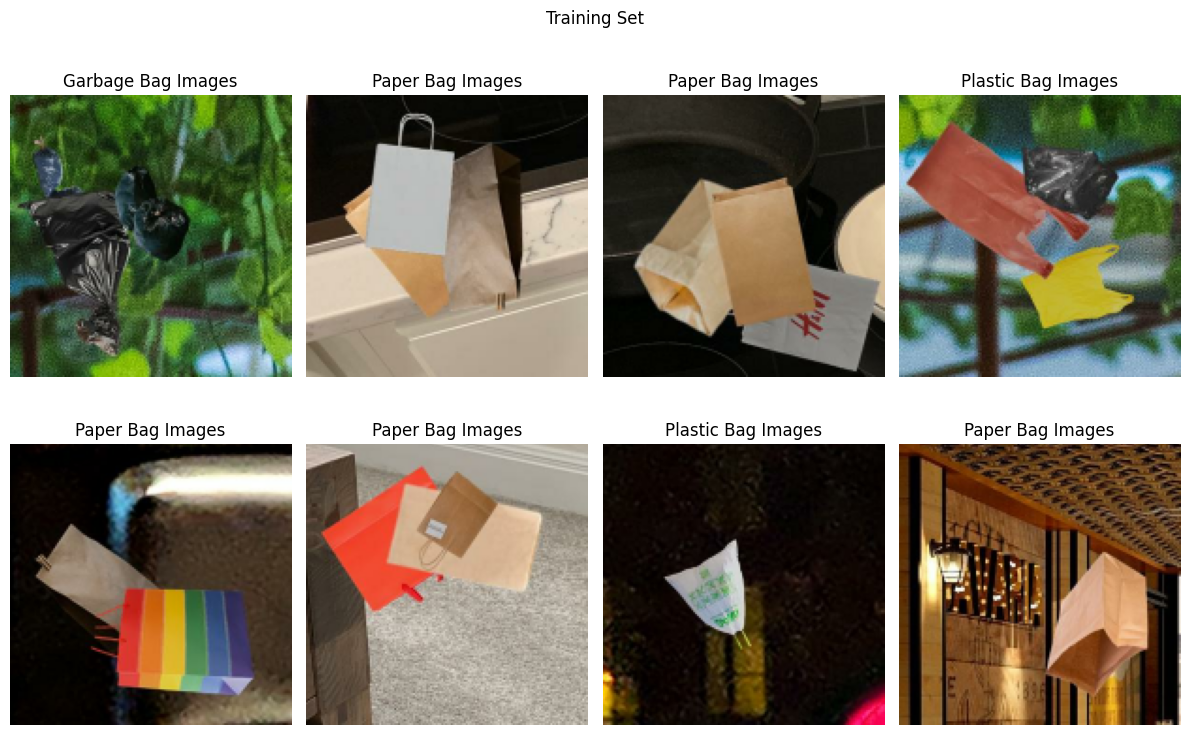

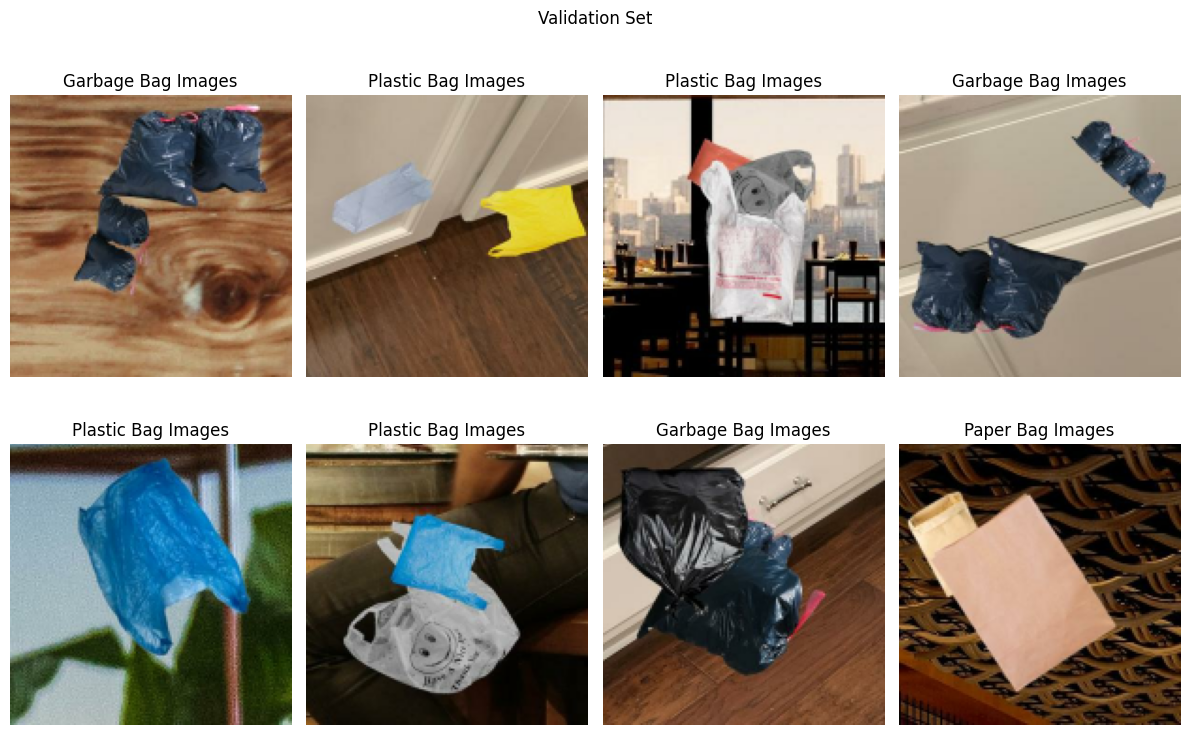

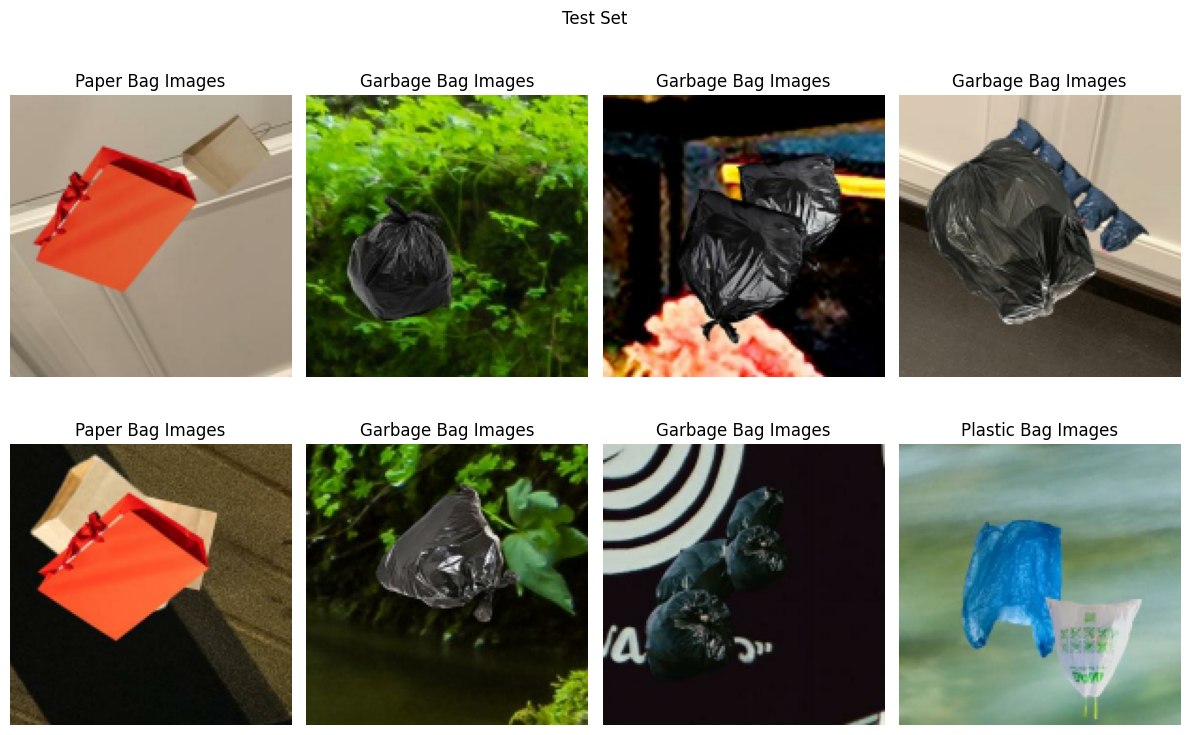

In [7]:
# Visualisasi sample foto pada masing masing split
class_names = train_ds.class_names

def show_images(dataset, title="Split Preview"):
    plt.figure(figsize=(12, 8))
    for images, labels in dataset.take(1):
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(train_ds, title="Training Set")
show_images(val_ds, title="Validation Set")
show_images(test_ds, title="Test Set")

## Modelling

In [8]:
# Data augmentasi
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("both"),
    layers.RandomRotation(0.3),
    layers.RandomShear(0.3),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.1)
])

Melakukan augmentasi sebagai berikut :
* RandomFlip = membalik gambar (saya menggunakan both yaitu membalik secara vertikal dan horizontal)
* RandomRotation = memutar atau rotasi gambar
* RandomShear = meregangkan atau melenturkan gambar
* RandomContrast = mengubah kontras pada gambar
* RandomZoom = memperbesar atau memperkecil gambar

In [9]:
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Membuat model Sequential dengan arsitektur :
* Menerapkan data hasil augmentasi lalu melakukan rescalling data
* Melakukan Convulation Layer menggunakan aktivasi 'relu' dan mengurangi fitur dengan MaxPooling Layer sebanyak tiga kali
* Menerapkan DropOut untuk menonaktifkan secara acak sejumlah unit selama pelatihan untuk mencegah overfitting
* Menerapkan Flatten Layer untuk meratakan output agar bisa diproses ke tahap berikutnya
* Terakhir Dense Layer menggunakan fungsi aktivasi 'relu' lalu diproses ke tahap menentukan hasil klasifikasi menggunakan fungsi aktivasi 'softmax' karna cocok untuk klasifikasi multiclass

Compile Model menggunakan :
* Optimizer menggunakan Adam
* Loss Function menggunakan 'categorical_crosentropy' karna cocok untuk data one-hot encoding
* metrics mengevaluasi performa 'accuracy' model selama pelatihan dan validasi.

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.96 and logs.get('accuracy')>0.96):
      print("\nAkurasi telah mencapai > 96%!")
      self.model.stop_training = True
callbacks = myCallback()

Membuat fungsi Callback yang akan dieksekusi jika 'Validation accuracy' dan 'Training accuracy' mencapai 96% maka akan menghentikan proses pelatihan supaya efisiensi waktu pelatihan

In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7193 - loss: 0.6493 - val_accuracy: 0.8867 - val_loss: 0.2839
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.8889 - loss: 0.3121 - val_accuracy: 0.9267 - val_loss: 0.1970
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9086 - loss: 0.2481 - val_accuracy: 0.9313 - val_loss: 0.1866
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9235 - loss: 0.2048 - val_accuracy: 0.9433 - val_loss: 0.1426
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9371 - loss: 0.1857 - val_accuracy: 0.9593 - val_loss: 0.1233
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9357 - loss: 0.1881 - val_accuracy: 0.9453 - val_loss: 0.1593
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9480 - loss: 0.1466 - val_accuracy: 0.9407 - val_loss: 0.1502
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9538 - loss: 0.1389 - 

dari 30 epoch kita berhasil mencapai akurasi dan validation akurasi yang sudah kita tentukan yaitu 96% pada epoch ke-18. Callbacks sangat berguna untuk efisiensi waktu pada pelatihan model

## Evaluasi dan Visualisasi

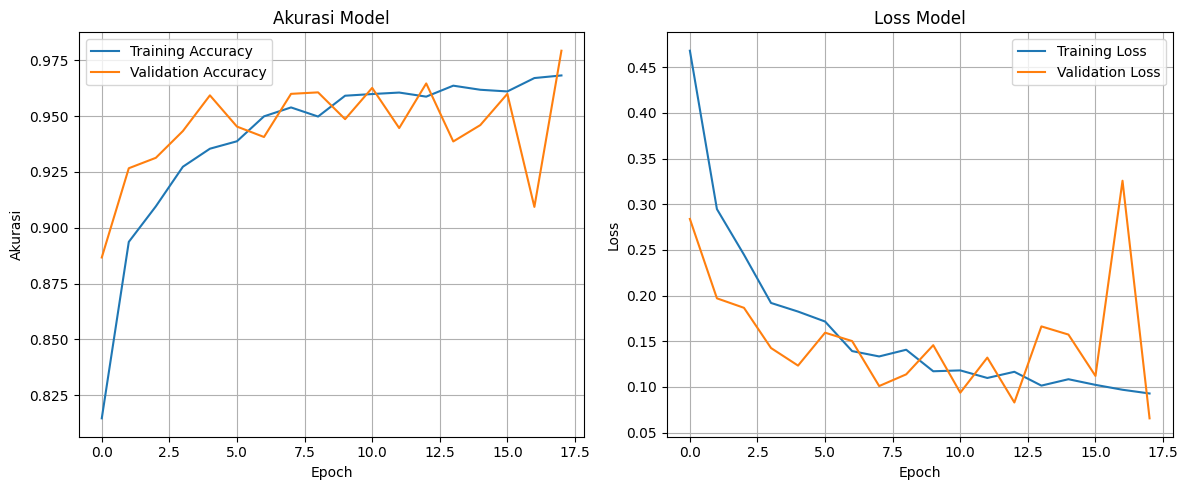

In [12]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Menampilkan plot akurasi dan plot loss model untuk melihat proses berjalannya pelatihan

In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Akurasi di test set: {test_acc:.2%}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9635 - loss: 0.0979
Akurasi di test set: 96.47%


Disini saya juga menambahkan akurasi pada Test set untuk melihat performa pada data Test. dan saya mendapatkan akurasi sebesar 96%

## Konversi Model

In [14]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


In [15]:
# Konversi ke Saved_model
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139311405536976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311405531216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311405534288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311405535824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311405535440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311371622480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311371628432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311371629776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311371630736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311371630544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311371631504: Te

In [16]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.experimental_new_converter = True  # Enable the new MLIR-based converter if available.
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Simpan model.tflite
os.makedirs("tflite", exist_ok=True)
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label.txt jika ada label
labels = ["Plastic Bag Images", "Paper Bag Images", "Garbage Bag Images"]
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

In [17]:
# Install TensorFlow.js converter
!pip install tensorflowjs

# Import library tensorflowjs
import tensorflowjs as tfjs

# Buat direktori untuk menyimpan model TFJS
!mkdir -p tfjs_model

# Simpan model ke format TFJS
tfjs.converters.save_keras_model(model, 'tfjs_model')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file


In [18]:
# Zip semua model yang disimpan
!zip -r model_artifacts.zip saved_model tfjs_model tflite
# Download hasil zip
files.download("model_artifacts.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 89%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 66%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: saved_model/assets/ (stored 0%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard5of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard4of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard1of5.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of5.bin (deflated 6%)
  adding: tfjs_model/model.json (deflated 86%)
  adding: tfjs_model/group1-shard3of5.bin (deflated 6%)
  adding: tflite/ (stored 0%)
  adding: tflite/label.txt (deflated 38%)
  adding: tflite/model.tflite (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Berhasil menyimpan model ke dalam folder
* saved_model
* tfjs_model
* tflite

## Inference (Optional)

In [19]:
# Load model dari folder SavedModel
model = tf.saved_model.load("saved_model")

In [20]:
# Upload file gambar (misal .jpg)
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

Saving test.jpg to test.jpg


Output prediksi: {'output_0': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.0373318 , 0.7256368 , 0.23703147]], dtype=float32)>}
Prediksi kelas: 0
Prediksi label: plastic_bag


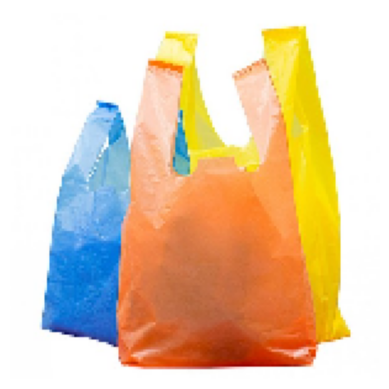

In [21]:
# Load dan resize gambar
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalisasi
img_array = np.expand_dims(img_array, axis=0)  # tambah batch dimensi

# predictions = model.predict(img_array)
# Cara baru dengan SavedModel
input_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
infer = model.signatures["serving_default"]
input_name = list(infer.structured_input_signature[1].keys())[0]
predictions = infer(**{input_name: input_tensor})

# Hasil prediksi (probabilitas per kelas)
print("Output prediksi:", predictions)
# Ambil kelas dengan skor tertinggi
class_index = np.argmax(predictions)
print("Prediksi kelas:", class_index)
# Kelas berdasarkan index
labels = ["plastic_bag", "paper_bag", "garbage_bag"]
print("Prediksi label:", labels[class_index])

plt.imshow(img)
plt.axis("off")
plt.show()

Prediksi berdasarkan unggahan foto sudah berhasil dan dapat memprediksi sesuai dengan kelas yang ada pada foto